In [1]:
import os
import numpy as np
import pandas as pd
import glob
import scipy.misc
import random
from shutil import copyfile
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow
from PIL import Image
from bs4 import BeautifulSoup
import xml.etree.cElementTree as ET
from numpy import linalg as LA

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10

In [2]:
from scipy.spatial import distance

def get_points_from_xml(xml_file):
    lymphocyte=['TIL-E', 'TIL-S']
    normal_epithelial=['normal', 'UDH', 'ADH']
    malignant_epithelial=['IDC', 'ILC', 'MucC', 'DCIS1', 'DCIS2', 'DCIS3', 'MC-E', 'MC-C', 'MC-M']
    
    with open(xml_file) as fp:
        soup = BeautifulSoup(fp, 'xml')
    groups=soup.find_all('graphic')

    num_pos = 0
    all_points=[]
    for group in groups:
        points=group.find_all('point')

        nucleus_type = group.get('description').replace(" ", "")
        if (nucleus_type in lymphocyte):
            label = '1'
        elif (nucleus_type in normal_epithelial):
            label = '2'
        elif (nucleus_type in malignant_epithelial):
            label = '3'
        else:
            # convention is to use the last valid label, meaning we shouldn't change the label variable 
            try:
                label
            except NameError:
                print("Error, no matching label with no prev obs - set var to 3")
                print('nucleus_type is: ', nucleus_type)
                print('File is ', xml_file)
                label = 3
            else:
                print ("Error, set var to prev obs: ", label)
                print ('nucleus_type is: ', nucleus_type)
                print ('File is ', xml_file)

        for point in points:
            x=int(point.get_text().rsplit(',', 1)[0])
            y=int(point.get_text().rsplit(',', 1)[1])
            all_points.append([x,y, label])
    all_points = np.array(all_points).astype(float)
    return all_points


def create_all_imgs(data_loc, out_dir):
    all_files=glob.glob(os.path.join(data_loc, '*'))
    all_images = [loc for loc in all_files if loc.rsplit('.', 1)[-2][-4:] == 'crop']
    folder_size = len(all_images)
    print('folder_size: ', folder_size)
    
    for image_file in all_images:
        xml_file = image_file.rsplit('_', 1)[0]+'_key.xml'
        points = get_points_from_xml(xml_file)

        image = np.array(Image.open(image_file))
        im_name = image_file.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('_', 1)[0].replace(" ", "_")
        
        dist_map=np.zeros(image.shape)
        
        for y in range(image.shape[0]): # rows
            print(y)
            for x in range(image.shape[1]): # cols
                dists= cdist(np.array([x,y]), points[:, 0:2], 'euclidean')
                if (len(dists)==0):
                    print('problem')
                    break
                else:
                    min_ind = np.argmin(dists)
                    min_dist = dists[min_ind]
                    dist_map[y, x, 0] = points[min_ind, ]
                    dist_map[y, x, 1] = points[min_ind, 2]
                    
        out_name = os.path.join(out_dir, image_file.rsplit('/', 1)[1])
                    
############################################################
#         dist_map=np.zeros(image.shape)
        
#         def do_kdtree(all_locations,points):
#             mytree = scipy.spatial.cKDTree(combined_x_y_arrays)
#             dist, indexes = mytree.query(points)
#             return indexes
        
        
#         all_locations = numpy.dstack([y_array.ravel(),x_array.ravel()])[0]
#         points_list = list(points.transpose())
#         start = time.time()
#         results2 = do_kdtree(combined_x_y_arrays,points_list)
        
#         for y in range(image.shape[0]): # rows
#             print(y)
#             for x in range(image.shape[1]): # cols
#                 dists= cdist(np.array([x,y]), points[:, 0:2], 'euclidean')
#                 if (len(dists)==0):
#                     print('problem')
#                     break
#                 else:
#                     min_ind = np.argmin(dists)
#                     min_dist = dists[min_ind]
#                     dist_map[y, x, 0] = points[min_ind, ]
#                     dist_map[y, x, 1] = points[min_ind, 2]   
    

folder_size:  22
/home/rbbidart/project/rbbidart/cancer_hist/full_slides2/valid/47_Region_3_crop.tif
47_Region_3
image.shape (434, 668, 3)
points.shape (158, 3)
[ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


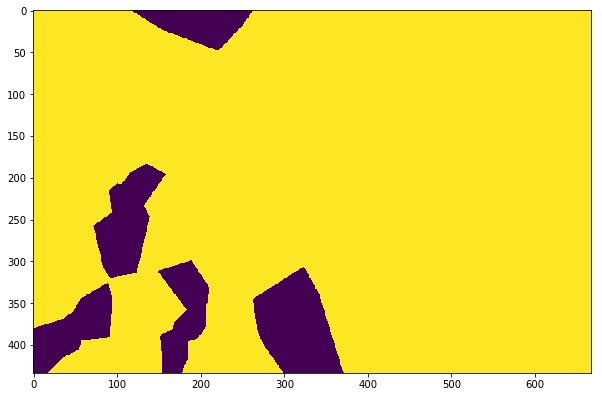

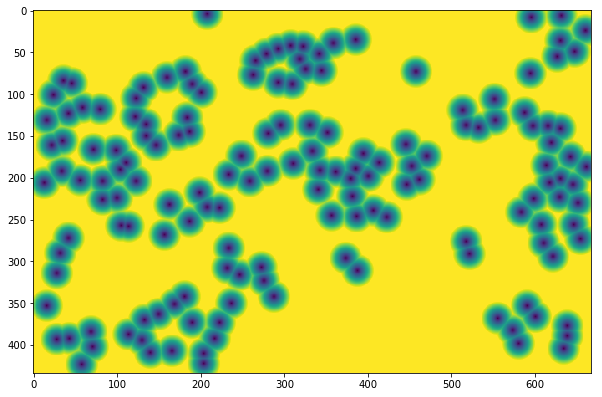

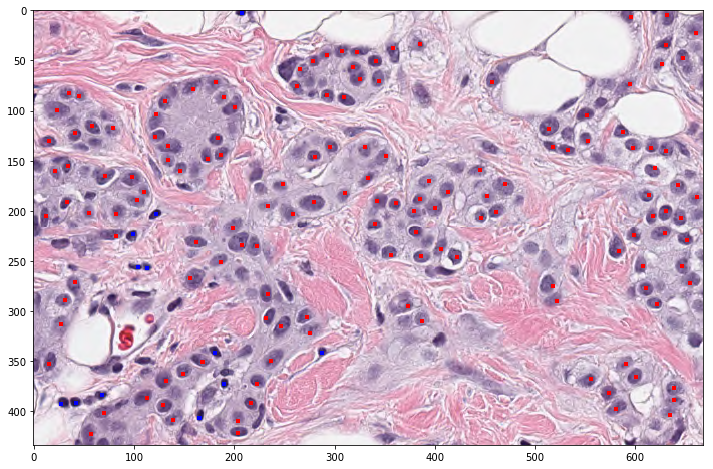

In [23]:
from scipy.spatial.distance import cdist

data_loc = '/home/rbbidart/project/rbbidart/cancer_hist/full_slides2/valid'

all_files=glob.glob(os.path.join(data_loc, '*')) 
all_images = [loc for loc in all_files if loc.rsplit('.', 1)[-2][-4:] == 'crop']

    
folder_size = len(all_images)
print('folder_size: ', folder_size)

for image_file in all_images[6:7]:
    xml_file = image_file.rsplit('_', 1)[0]+'_key.xml'
    points = get_points_from_xml(xml_file)

    image = np.array(Image.open(image_file))
    im_name = image_file.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('_', 1)[0].replace(" ", "_")
    print(image_file)
    print(im_name)
    print('image.shape', image.shape)
    print('points.shape', points.shape)

    dist_map=np.zeros(image.shape)

    for y in range(image.shape[0]): # rows
        for x in range(image.shape[1]): # cols
            dists = np.sqrt(np.sum((points[:, 0:2] -  np.array([x, y])) ** 2, axis=1))
#             dists = np.sqrt(np.sum((points - np.array([y, x])) ** 2, axis=1))
            if (len(dists)==0):
                print('problem')
                break
            else:
                min_ind = np.argmin(dists)
                min_dist = dists[min_ind]
                dist_map[y, x, 0] = min_dist
                dist_map[y, x, 1] = points[min_ind, 2]

    print(points[:, 2])

    plt.figure(figsize=(10,12))
    plt.imshow(dist_map[:, :, 1])
    dist_map[dist_map > 20] = 20
    plt.figure(figsize=(10,12))
    plt.imshow(dist_map[:, :, 0])

    
    f = plt.figure(figsize=(12,15))
    image2 = np.asarray(image).astype(int)
    for row in range(len(points)):
        if points[row, 2] == 1:
            color = [0, 0, 255]
        elif points[row, 2] == 2:
            color = [0, 255, 0]  
        elif points[row, 2] == 3:
            color = [255, 0, 0]
        image2[int(points[row, 1])-2:int(points[row, 1])+2, int(points[row, 0])-2:int(points[row, 0])+2, :] = color
    plt.imshow(image2.astype(np.uint8))

In [ ]:
plt.imshow(image2.astype(np.uint8))